**Measuring Bias in multiclass classification**

**Load the data**

In [ ]:
!pip install holisticai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.8/272.8 kB 920.0 kB/s eta 0:00:00


In [ ]:
# Imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from holisticai.datasets import load_student
# load data
df = load_student()['frame']
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [ ]:
df.shape

(395, 33)

In [ ]:
df.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [ ]:
# Make data multiclass by slicing into 4 buckets
y = df['G3'].to_numpy()
buckets = np.array([8, 11, 14])
y_cat = (y.reshape(-1, 1) > buckets.reshape(1, -1)).sum(axis=1)
df['target'] = y_cat

# map dictionary
grade_dict = {0:'very-low', 1:'low', 2:'high',3:'very-high'}
df['target'] = df['target'].map(grade_dict)

# drop the other grade columns
df = df.drop(columns=['G1','G2','G3'])

df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,target
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,very-low
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,very-low
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,low
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,very-high
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,no,no,5,5,4,4,5,4,11,low
391,MS,M,17,U,LE3,T,3,1,services,services,...,yes,no,2,4,5,3,4,2,3,very-high
392,MS,M,21,R,GT3,T,1,1,other,other,...,no,no,5,5,3,3,3,3,3,very-low
393,MS,M,18,R,LE3,T,3,2,services,other,...,yes,no,4,4,1,3,4,5,0,low


**Data Exploration**

<Axes: >

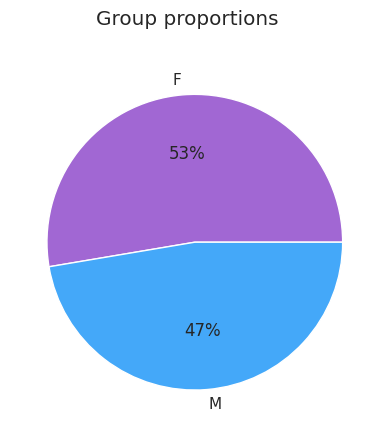

In [ ]:
from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import histogram_plot
from holisticai.bias.plots import frequency_matrix_plot
from holisticai.bias.plots import frequency_plot
group_pie_plot(df['sex'])

<Axes: >

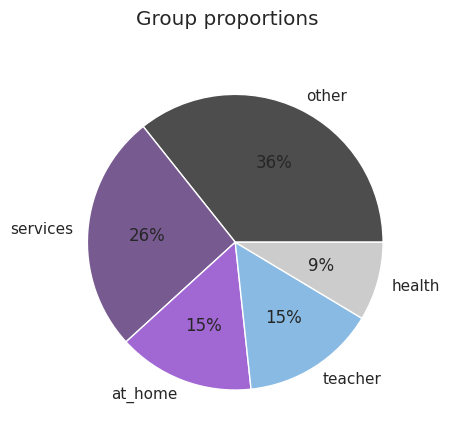

In [ ]:
group_pie_plot(df['Mjob'])

<Axes: xlabel='target', ylabel='Probability'>

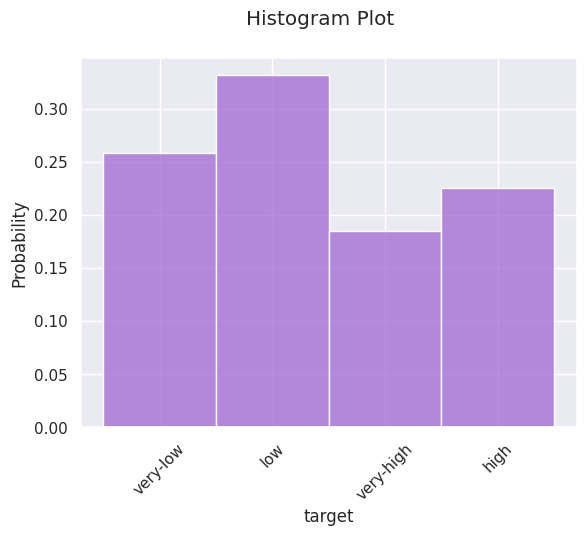

In [ ]:
histogram_plot(df['target'])

<Axes: xlabel='Class', ylabel='Group'>

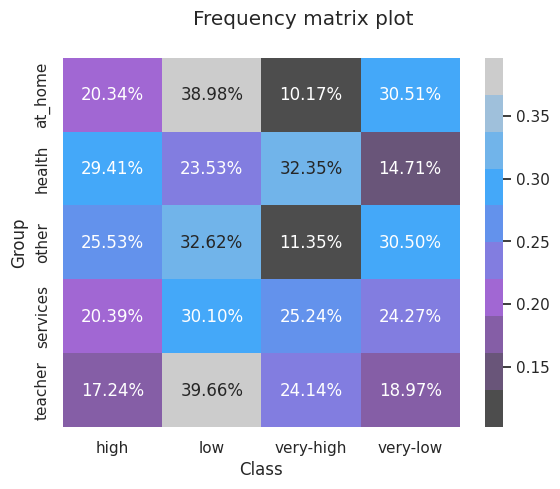

In [ ]:
frequency_matrix_plot(df['Mjob'], df['target'], normalize='group')

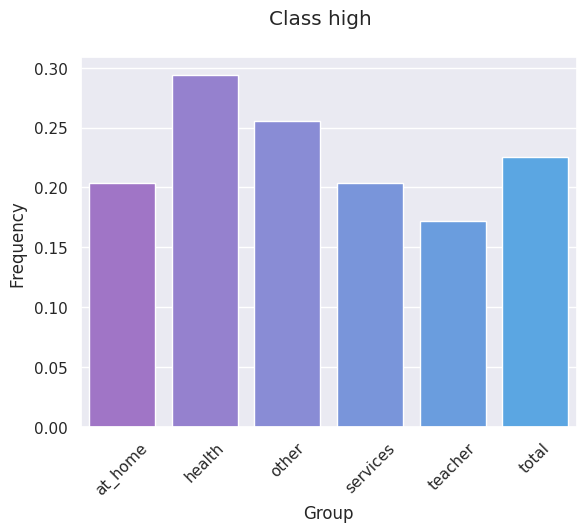

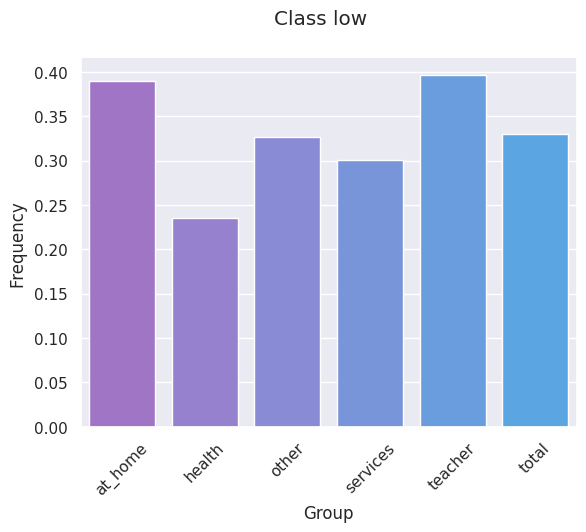

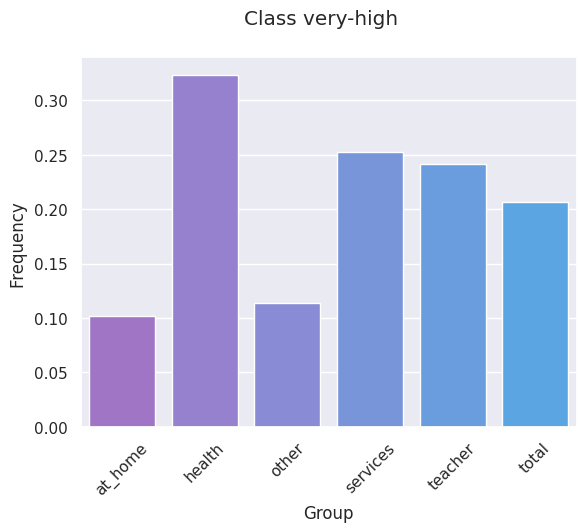

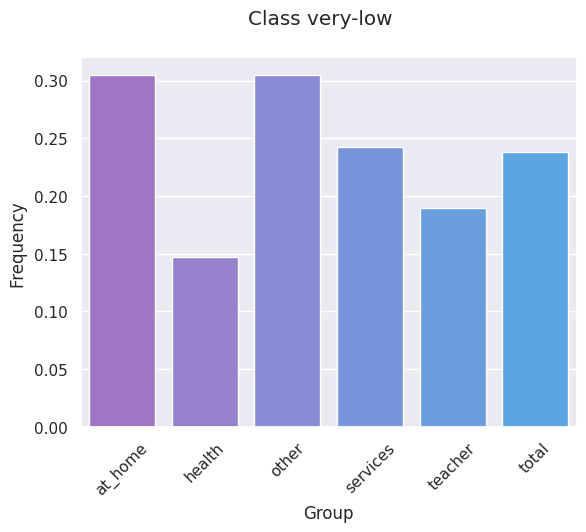

In [ ]:
frequency_plot(df['Mjob'], df['target'])

**Train a model**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
# preprocess categorical columns
def preprocess_data(data, protected_attributes, label_attributes):
    categoricals = []
    for col in data.columns:
        if col not in protected_attributes and col not in label_attributes and data[col].dtype == object:
            categoricals.append(col)

    cat_encoder = OneHotEncoder()
    enc = cat_encoder.fit_transform(data[categoricals])
    enc = pd.DataFrame(enc.toarray())
    df = pd.concat([data,enc],axis=1).drop(columns=categoricals) # add encoded columns
    df = df.rename(str, axis='columns')
    return df
# don't encode protected attributes
protected_attributes = ['sex', 'address', 'Mjob', 'Fjob']
label_attributes = ['target']

# Load, preprocess and split for training
preproc_data = preprocess_data(df, protected_attributes, label_attributes)
train, test = train_test_split(preproc_data, test_size=0.4, random_state=42)

preproc_data

,sex,age,address,Medu,Fedu,Mjob,Fjob,traveltime,studytime,failures,...,19,20,21,22,23,24,25,26,27,28
0,F,18,U,4,4,at_home,teacher,2,2,0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,F,17,U,1,1,at_home,other,1,2,0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,F,15,U,1,1,at_home,other,1,2,3,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,F,15,U,4,2,health,services,1,3,0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,F,16,U,3,3,other,other,1,2,0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,M,20,U,2,2,services,services,1,2,2,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
391,M,17,U,3,1,services,services,2,1,0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
392,M,21,R,1,1,other,other,1,1,3,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
393,M,18,R,3,2,services,other,3,1,0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [ ]:
# set up data for training
X_train = train.drop(columns=label_attributes)
X_test = test.drop(columns=label_attributes)
y_train = train['target']
y_test = test['target']

# Train a simple Random Forest Classifier
model = RandomForestClassifier(random_state=111)
model.fit(X_train.drop(columns=protected_attributes), y_train)

# Predict values
y_pred = model.predict(X_test.drop(columns=protected_attributes))
from holisticai.bias.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
confusion_matrix(y_pred, y_test, classes=['very-low','low','high','very-high'])

,very-low,low,high,very-high
very-low,18.0,4.0,1.0,2.0
low,19.0,32.0,22.0,10.0
high,7.0,8.0,8.0,11.0
very-high,3.0,3.0,2.0,8.0


In [ ]:
print (accuracy_score(y_test, y_pred))
print (precision_score(y_test, y_pred, average=None, labels=['very-low','low','high','very-high']))
print (recall_score(y_test, y_pred, average=None, labels=['very-low','low','high','very-high']))

0.4177215189873418
[0.72       0.38554217 0.23529412 0.5       ]
[0.38297872 0.68085106 0.24242424 0.25806452]


**Measure bias**

<Axes: xlabel='Class', ylabel='Group'>

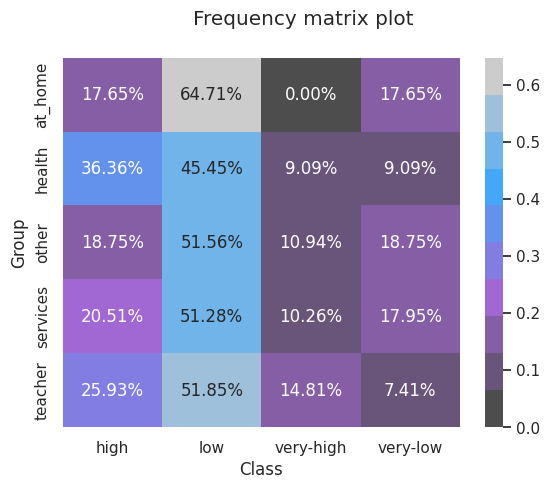

In [ ]:
from holisticai.bias.plots import frequency_matrix_plot
from holisticai.bias.plots import frequency_plot
# set up vectors
p_attr = test['Mjob']                                               # protected attribute
y_pred = model.predict(X_test.drop(columns=protected_attributes))   # multiclass prediction vector
y_true = y_test                                                     # multiclass label vector
frequency_matrix_plot(p_attr, y_pred, normalize='group')

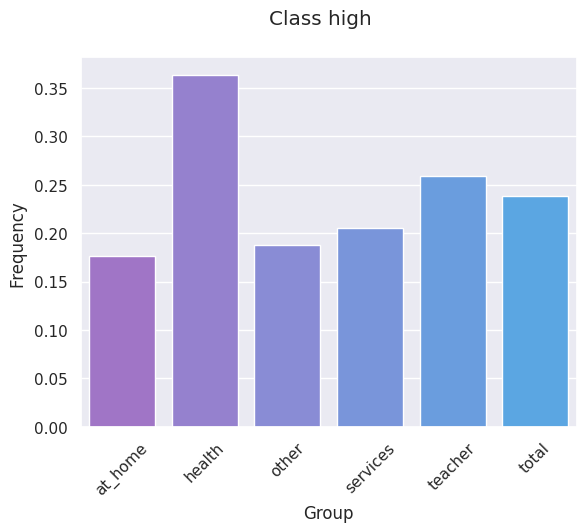

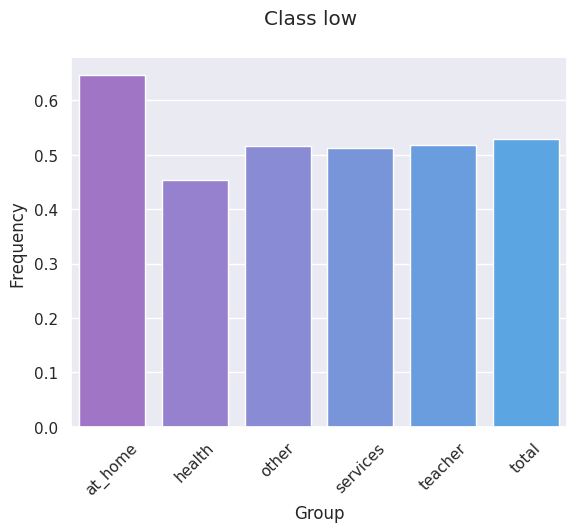

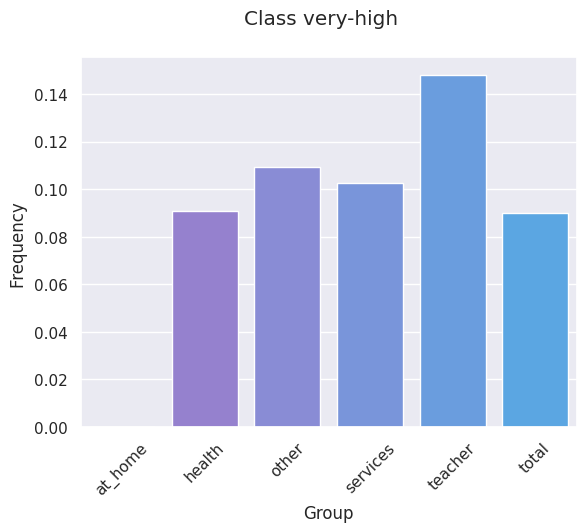

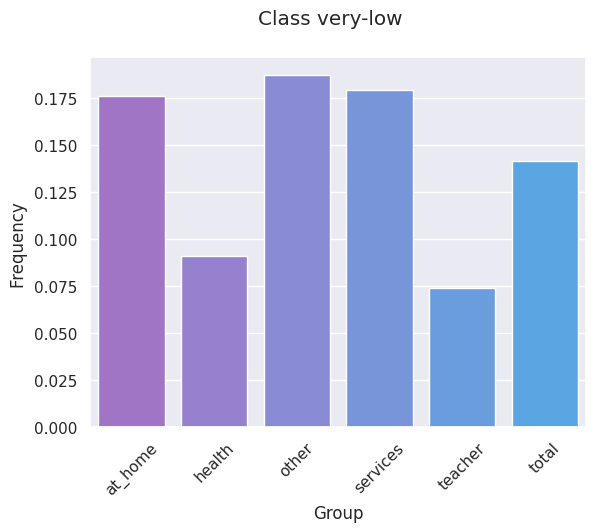

In [ ]:
frequency_plot(p_attr, y_pred)

In [ ]:
from holisticai.bias.metrics import multiclass_statistical_parity

multiclass_statistical_parity(
    p_attr, y_pred, groups=None, classes=None, aggregation_fun="mean"
)

0.14670076995444642

Statistical parity, generalized for the multiclass case. We aggregate by taking the average multilabel statistical parity over all possible group pairs (aggregation_fun="mean"). As in the 1d case, the suggested accepted range is (-0.1, 0.1).

In [ ]:
multiclass_statistical_parity(
    p_attr, y_pred, groups=None, classes=None, aggregation_fun="max"
)

0.2780748663101605

Alternatively, we could aggregate by taking the maximum (aggregation_fun="max") over all possible group pairs.


In [ ]:
from holisticai.bias.metrics import multiclass_equality_of_opp

multiclass_equality_of_opp(
    p_attr, y_pred, y_true, groups=None, classes=None, aggregation_fun="mean"
)

0.3420002687529861

In [ ]:
multiclass_equality_of_opp(
    p_attr, y_pred, y_true, groups=None, classes=None, aggregation_fun="max"
)

0.46875

**Bias measuring and mitigation in multiclassification tasks**

**1. Data loading and packages installation**


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from holisticai.datasets import load_us_crime
from sklearn.model_selection import train_test_split
# Settings
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
dataset = load_us_crime()
df = pd.concat([dataset["data"], dataset["target"]], axis=1)
df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8.0,NaN,NaN,Lakewoodcity,1.0,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53.0,NaN,NaN,Tukwilacity,1.0,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24.0,NaN,NaN,Aberdeentown,1.0,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34.0,5.0,81440.0,Willingborotownship,1.0,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42.0,95.0,6096.0,Bethlehemtownship,1.0,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [ ]:
df.shape

(1994, 128)

In [ ]:
df.describe()

,state,county,community,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
count,1994.000000,820.000000,817.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,319.000000,319.000000,319.000000,319.000000,1994.000000,319.000000,1994.000000
mean,28.683551,58.826829,46188.336597,5.493982,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,...,0.065231,0.232854,0.161685,0.163103,0.076708,0.698589,0.440439,0.094052,0.195078,0.237979
std,16.397553,126.420560,25299.726569,2.873694,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,...,0.109459,0.203092,0.229055,0.214778,0.140207,0.213944,0.405808,0.240328,0.164718,0.232985
min,1.000000,1.000000,70.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,9.000000,25065.000000,3.000000,0.010000,0.350000,0.020000,0.630000,0.040000,0.010000,...,0.020000,0.100000,0.020000,0.040000,0.020000,0.620000,0.000000,0.000000,0.110000,0.070000
50%,34.000000,23.000000,48090.000000,5.000000,0.020000,0.440000,0.060000,0.850000,0.070000,0.040000,...,0.040000,0.170000,0.070000,0.080000,0.030000,0.750000,0.500000,0.000000,0.150000,0.150000
75%,42.000000,59.500000,66660.000000,8.000000,0.050000,0.540000,0.230000,0.940000,0.170000,0.160000,...,0.070000,0.280000,0.190000,0.195000,0.060000,0.840000,1.000000,0.000000,0.220000,0.330000
max,56.000000,840.000000,94597.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**2. Dataset preprocessing**

In [ ]:
df.isna().sum()

state                     0
county                 1174
community              1177
communityname             0
fold                      0
                       ... 
LemasPctPolicOnPatr    1675
LemasGangUnitDeploy    1675
LemasPctOfficDrugUn       0
PolicBudgPerPop        1675
ViolentCrimesPerPop       0
Length: 128, dtype: int64

In [ ]:
def preprocess_us_crime_dataset(df, protected_feature):
  """Performs the pre-processing step of the data."""
  # Remove NaN elements from dataframe
  df_ = df.copy()
  df_clean = df_.iloc[:,[i for i,n in enumerate(df_.isna().sum(axis=0).T.values) if n<1000]]
  df_clean = df_clean.dropna()
  # Get the protected attribute vectors
  group_a = df_clean[protected_feature].apply(lambda x: x>0.5)
  group_b =  1-group_a
  group_b = group_b.astype('bool')
  # Remove unnecessary columns
  cols = [c for c in df_clean.columns if (not c.startswith('race')) and (not c.startswith('age'))]
  df_clean = df_clean[cols].iloc[:,3:]
  return df_clean, group_a, group_b
df_clean, group_a, group_b = preprocess_us_crime_dataset(df, 'racePctWhite')
df.shape, df_clean.shape

((1994, 128), (1993, 93))

In [ ]:
# Transform the target column in order to have a multiclass column
def convert_float_to_categorical(target, nb_classes, numeric_classes=True):
    eps = np.finfo(float).eps
    if numeric_classes:
        labels = list(range(nb_classes))
    else:
        labels = [f"Q{c}-Q{c+1}" for c in range(nb_classes)]
    labels_values = np.linspace(0, 1, nb_classes + 1)
    v = np.array(target.quantile(labels_values)).squeeze()
    v[0], v[-1] = v[0] - eps, v[-1] + eps
    y = target.copy()
    for (i, c) in enumerate(labels):
        y[(target.values >= v[i]) & (target.values < v[i + 1])] = c
    return y.astype(np.int32)
nb_classes = 5

X = df_clean.iloc[:, :-1]
y = convert_float_to_categorical(df_clean.iloc[:, -1], nb_classes=nb_classes)

**3. Data analysis**

<Axes: >

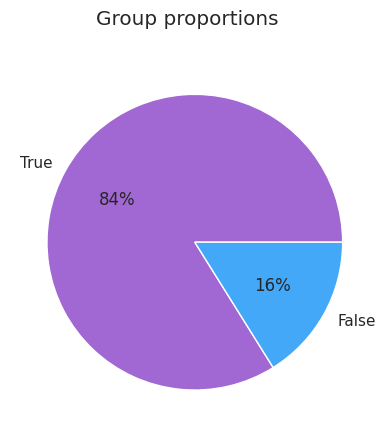

In [ ]:
group_pie_plot(group_a)

<Axes: >

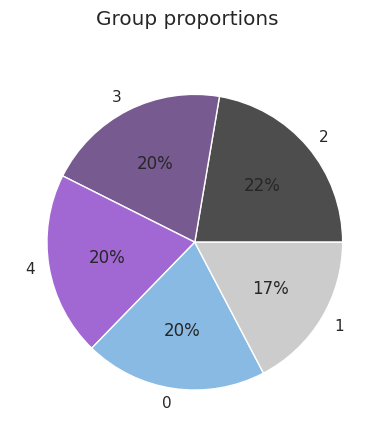

In [ ]:
group_pie_plot(y)

**Inference:** The previous graphs show us that the proportion of white people is high compared to the remain, and the target disctribution is almost the same for all the classes.

In [ ]:
X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
    train_test_split(X, y, group_a, group_b, test_size=0.2, random_state=42)
train_data = X_train, y_train, group_a_tr, group_b_tr
test_data  = X_test, y_test, group_a_ts, group_b_ts

**4. Model training**

In [ ]:
from holisticai.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from holisticai.utils.transformers.bias import SensitiveGroups
# efficacy metrics from sklearn
from sklearn import metrics

# dictionnary of metrics
metrics_dict={
        "Accuracy": metrics.accuracy_score,
        "Balanced accuracy": metrics.balanced_accuracy_score,}

# efficacy metrics dataframe helper tool
def metrics_dataframe(y_pred, y_true, metrics_dict=metrics_dict):
    metric_list = [[pf, fn(y_true, y_pred)] for pf, fn in metrics_dict.items()]
    return pd.DataFrame(metric_list, columns=["Metric", "Value"]).set_index("Metric")
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

LR = LogisticRegression()
model = LR.fit(X, y)

X, y, group_a, group_b = test_data
X = scaler.transform(X)

y_pred = model.predict(X)
metrics_dataframe(y_pred, y, metrics_dict=metrics_dict)

,Value
Metric,
Accuracy,0.466165
Balanced accuracy,0.459036


**5. Bias measuring**

**multiclass_bias_metrics** function allows us to select which metrics we want to calculate, if equal_outcome, equal_opportunity or both, where equal_outcome shows how disadvantaged groups are treated by the model and equal_opportunity shows if all the groups have the same opportunities.

In [ ]:
from holisticai.bias.metrics import multiclass_bias_metrics
sensgroup = SensitiveGroups()
p_attr = sensgroup.fit_transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_baseline = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_baseline

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.642819,0
Mean Multiclass Statistical Parity,0.642819,0
Max Multiclass Equality of Opportunity,0.491702,0
Max Multiclass Average Odds,0.402064,0
Max Multiclass True Positive Difference,0.315663,0
Mean Multiclass Equality of Opportunity,0.491702,0
Mean Multiclass Average Odds,0.402064,0
Mean Multiclass True Positive Difference,0.315663,0


**Multiclass Statistical parity:** Computes the statistical parity between multiple classes and a protected attribute with multiple groups. For each group computes the vector of success rates for entering each class, finally uses the mean or max strategies to aggregate them. Same as the 1d case, values in the range (-0.1, 0.1) are considered acceptable.

**Multiclass Equality of Opportunity:** Computes the matrix of error rates for each group, then computes all distances (mean absolute deviation) between such matrices, finally uses the mean or max strategies to aggregate them. Same as the 1d case, values in the range (-0.1, 0.1) are considered acceptable.

**Multiclass Average Odds:** Computes the matrix of error rates for each group, then averages these matrices over rows, and computes all pairwise distances between the resulting vectors, finally uses the mean or max strategies to aggregate them. Same as the 1d case, values in the range (-0.1, 0.1) are considered acceptable.

**Multiclass True Positive Difference:** Computes the matrix of error rates for each group, then computes all pairwise distances between the diagonal of such matrices, finally uses the mean or max strategies to aggregate them. Same as the 1d case, values in the range (-0.1, 0.1) are considered acceptable.

**6.a Bias mitigation**
**Correlation remover: Preprocessing method**

"Correlation remover" method is a pre-processing technique that applies a linear transformation to the non-sensitive features of the dataset to remove the correlation with respect to the sensitive columns. This process is done aiming to maintain as much as possible to prevent lost information.

**Traditional implementation**

In [ ]:
from holisticai.bias.mitigation import CorrelationRemover
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

preprocessing_mitigator = CorrelationRemover()

fit_params = {"group_a": group_a, "group_b": group_b}

X = preprocessing_mitigator.fit_transform(X, **fit_params)

model = LogisticRegression()

model.fit(X, y)

X, y, group_a, group_b = test_data
fit_params = {"group_a": group_a, "group_b": group_b}

X = scaler.transform(X)
X = preprocessing_mitigator.transform(X, **fit_params)

y_pred = model.predict(X)

p_attr = sensgroup.fit_transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_corr_rem = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_corr_rem

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.422266,0
Mean Multiclass Statistical Parity,0.422266,0
Max Multiclass Equality of Opportunity,0.425937,0
Max Multiclass Average Odds,0.251931,0
Max Multiclass True Positive Difference,0.363020,0
Mean Multiclass Equality of Opportunity,0.425937,0
Mean Multiclass Average Odds,0.251931,0
Mean Multiclass True Positive Difference,0.363020,0


**Pipeline implementation**

In [ ]:
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", CorrelationRemover()),
        ("model", LogisticRegression()),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)

p_attr = sensgroup.transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_corr_rem_w_p = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_corr_rem_w_p

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.422266,0
Mean Multiclass Statistical Parity,0.422266,0
Max Multiclass Equality of Opportunity,0.425937,0
Max Multiclass Average Odds,0.251931,0
Max Multiclass True Positive Difference,0.363020,0
Mean Multiclass Equality of Opportunity,0.425937,0
Mean Multiclass Average Odds,0.251931,0
Mean Multiclass True Positive Difference,0.363020,0


**7.a Results comparison**


In [ ]:
result = pd.concat([df_baseline, df_corr_rem, df_corr_rem_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Max Multiclass Statistical Parity,0.642819,0.422266,0.422266,0
Mean Multiclass Statistical Parity,0.642819,0.422266,0.422266,0
Max Multiclass Equality of Opportunity,0.491702,0.425937,0.425937,0
Max Multiclass Average Odds,0.402064,0.251931,0.251931,0
Max Multiclass True Positive Difference,0.315663,0.363020,0.363020,0
Mean Multiclass Equality of Opportunity,0.491702,0.425937,0.425937,0
Mean Multiclass Average Odds,0.402064,0.251931,0.251931,0
Mean Multiclass True Positive Difference,0.315663,0.363020,0.363020,0


In [ ]:
def calculate_metrics(train_data, test_data, alpha, metrics_cols):
  from sklearn.metrics import accuracy_score
  model = LogisticRegression()
  pipeline = Pipeline(
      steps=[
          ('scalar', StandardScaler()),
          ("bm_preprocessing", CorrelationRemover(alpha=alpha)),
          ("model", model),
      ]
  )

  X, y, group_a, group_b = train_data
  fit_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b
  }

  pipeline.fit(X, y, **fit_params)

  X, y, group_a, group_b = test_data
  predict_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b,
  }
  y_pred = pipeline.predict(X, **predict_params)
  p_attr = sensgroup.transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

  df = multiclass_bias_metrics(
      p_attr,
      y_pred,
      y,
      metric_type='both'
  )
  # Calculate metrics
  metrics = [
      alpha,
      accuracy_score(y, y_pred)
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics
metrics_val = []
metrics_cols = ['Max Multiclass Statistical Parity', 'Max Multiclass Equality of Opportunity']

for alphas in np.linspace(0,1.5,12):
  metrics_val.append(calculate_metrics(train_data, test_data, alphas, metrics_cols))

metrics = ['alpha', 'accuracy']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

,alpha,accuracy,Max Multiclass Statistical Parity,Max Multiclass Equality of Opportunity
0,0.000000,0.466165,0.642819,0.491702
1,0.136364,0.473684,0.628327,0.478287
2,0.272727,0.466165,0.564822,0.430314
3,0.409091,0.458647,0.535837,0.406645
4,0.545455,0.446115,0.517128,0.400953
5,0.681818,0.443609,0.480237,0.398133
6,0.818182,0.443609,0.466930,0.402289
7,0.954545,0.438596,0.436759,0.399072
8,1.090909,0.433584,0.411067,0.424333
9,1.227273,0.431078,0.399605,0.420964


Text(0.5, 0, 'alpha')

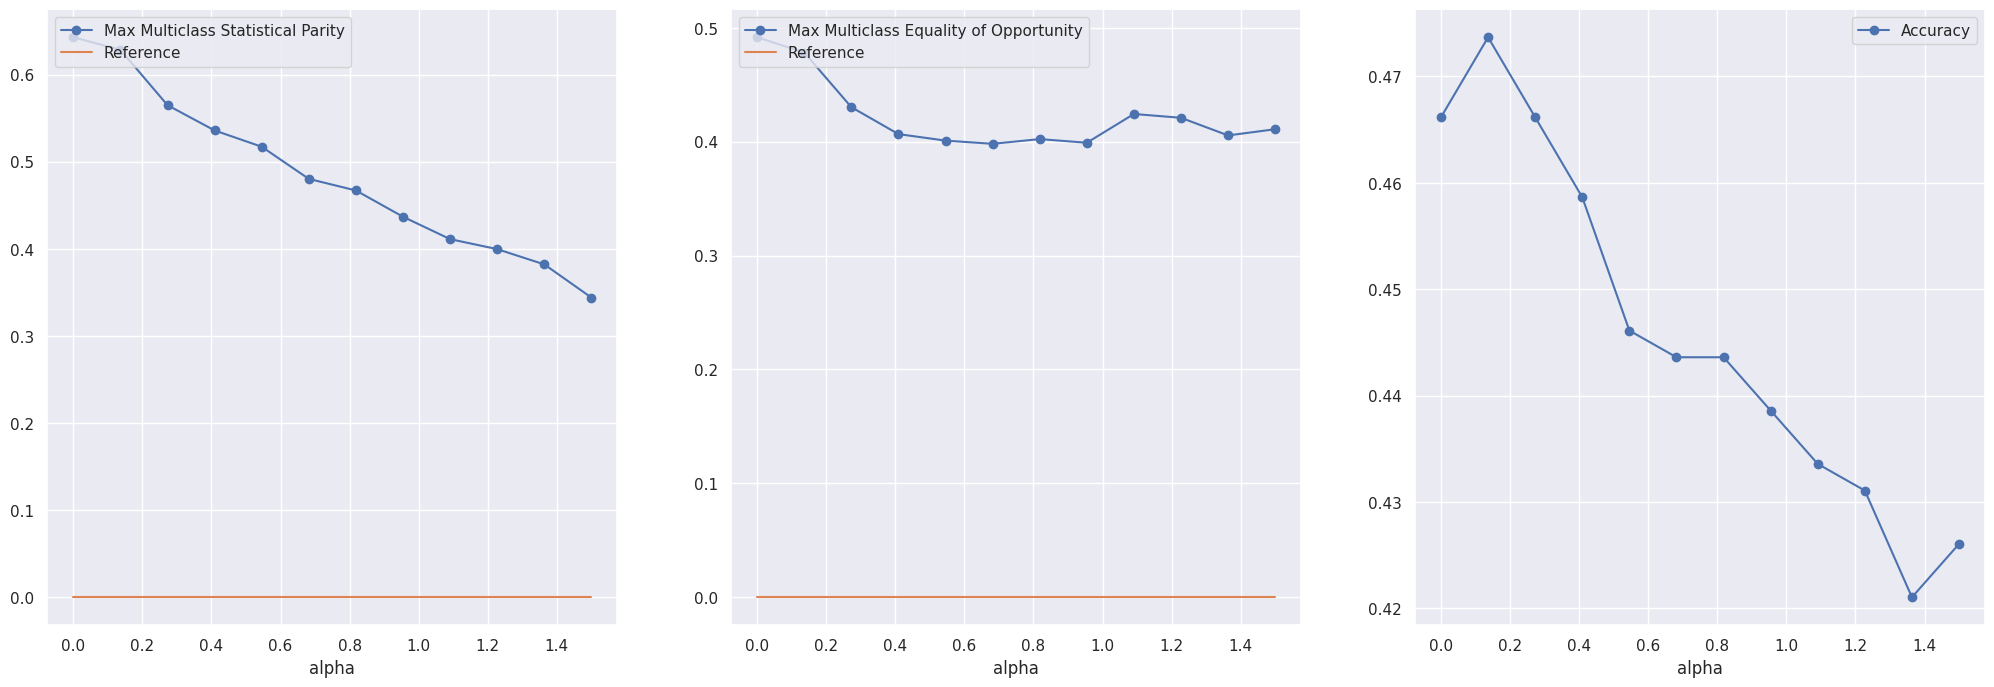

In [ ]:
x_axis = df_metrics.alpha
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(x_axis, df_metrics['Max Multiclass Statistical Parity'], 'o-', label='Max Multiclass Statistical Parity')
plt.plot(x_axis, np.zeros_like(df_metrics['Max Multiclass Statistical Parity']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.subplot(132)
plt.plot(x_axis, df_metrics['Max Multiclass Equality of Opportunity'], 'o-', label='Max Multiclass Equality of Opportunity')
plt.plot(x_axis, np.zeros_like(df_metrics['Max Multiclass Equality of Opportunity']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.subplot(133)
plt.plot(x_axis, df_metrics['accuracy'], 'o-', label='Accuracy')
plt.legend(loc='upper right')
plt.xlabel('alpha')

**6.b Bias mitigation**

**Disparate impact remover: Preprocessing method**

"Disparate impact remover" method is a pre-processing technique that uses perturbation to modify the values of the features such that the distributions of privileged and unprivileged groups are close in order to increase fairness.

**Traditional implementation**

In [ ]:
from holisticai.bias.mitigation import DisparateImpactRemover
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

preprocessing_mitigator = DisparateImpactRemover()

fit_params = {"group_a": group_a, "group_b": group_b}

X = preprocessing_mitigator.fit_transform(X, **fit_params)

model = LogisticRegression()

model.fit(X, y)

X, y, group_a, group_b = test_data
fit_params = {"group_a": group_a, "group_b": group_b}

X = scaler.transform(X)
X = preprocessing_mitigator.transform(X, **fit_params)

y_pred = model.predict(X)

p_attr = sensgroup.fit_transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_disprem = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_disprem

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.461001,0
Mean Multiclass Statistical Parity,0.461001,0
Max Multiclass Equality of Opportunity,0.341800,0
Max Multiclass Average Odds,0.204341,0
Max Multiclass True Positive Difference,0.088523,0
Mean Multiclass Equality of Opportunity,0.341800,0
Mean Multiclass Average Odds,0.204341,0
Mean Multiclass True Positive Difference,0.088523,0


**Pipeline implementation**

In [ ]:
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", DisparateImpactRemover()),
        ("model", LogisticRegression()),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)

p_attr = sensgroup.transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_disprem_w_p = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_disprem_w_p

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.461001,0
Mean Multiclass Statistical Parity,0.461001,0
Max Multiclass Equality of Opportunity,0.341800,0
Max Multiclass Average Odds,0.204341,0
Max Multiclass True Positive Difference,0.088523,0
Mean Multiclass Equality of Opportunity,0.341800,0
Mean Multiclass Average Odds,0.204341,0
Mean Multiclass True Positive Difference,0.088523,0


**7.b Results comparison**

In [ ]:
result = pd.concat([df_baseline, df_disprem, df_disprem_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Max Multiclass Statistical Parity,0.642819,0.461001,0.461001,0
Mean Multiclass Statistical Parity,0.642819,0.461001,0.461001,0
Max Multiclass Equality of Opportunity,0.491702,0.341800,0.341800,0
Max Multiclass Average Odds,0.402064,0.204341,0.204341,0
Max Multiclass True Positive Difference,0.315663,0.088523,0.088523,0
Mean Multiclass Equality of Opportunity,0.491702,0.341800,0.341800,0
Mean Multiclass Average Odds,0.402064,0.204341,0.204341,0
Mean Multiclass True Positive Difference,0.315663,0.088523,0.088523,0


this method allows us to set a repair_level value which is a parameter to control the repair amount, where 0 means no repair while 1 is full repair.

In [ ]:
def calculate_metrics(train_data, test_data, repair_level, metrics_cols):
  from sklearn.metrics import accuracy_score
  model = LogisticRegression()
  pipeline = Pipeline(
      steps=[
          ('scalar', StandardScaler()),
          ("bm_preprocessing", DisparateImpactRemover(repair_level=repair_level)),
          ("model", model),
      ]
  )

  X, y, group_a, group_b = train_data
  fit_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b
  }

  pipeline.fit(X, y, **fit_params)

  X, y, group_a, group_b = test_data
  predict_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b,
  }
  y_pred = pipeline.predict(X, **predict_params)
  p_attr = sensgroup.transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

  df = multiclass_bias_metrics(
      p_attr,
      y_pred,
      y,
      metric_type='both'
  )
  # Calculate metrics
  metrics = [
      repair_level,
      accuracy_score(y, y_pred)
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics
metrics_val = []
metrics_cols = ['Max Multiclass Statistical Parity', 'Max Multiclass Equality of Opportunity']

for repair_values in np.linspace(0,1,6):
  metrics_val.append(calculate_metrics(train_data, test_data, repair_values, metrics_cols))

metrics = ['repair_value', 'Accuracy']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

,repair_value,Accuracy,Max Multiclass Statistical Parity,Max Multiclass Equality of Opportunity
0,0.0,0.466165,0.642819,0.491702
1,0.2,0.466165,0.613175,0.454172
2,0.4,0.476190,0.554545,0.422232
3,0.6,0.438596,0.525033,0.267768
4,0.8,0.436090,0.478524,0.340331
5,1.0,0.426065,0.461001,0.341800


Text(0.5, 0, 'repair_value')

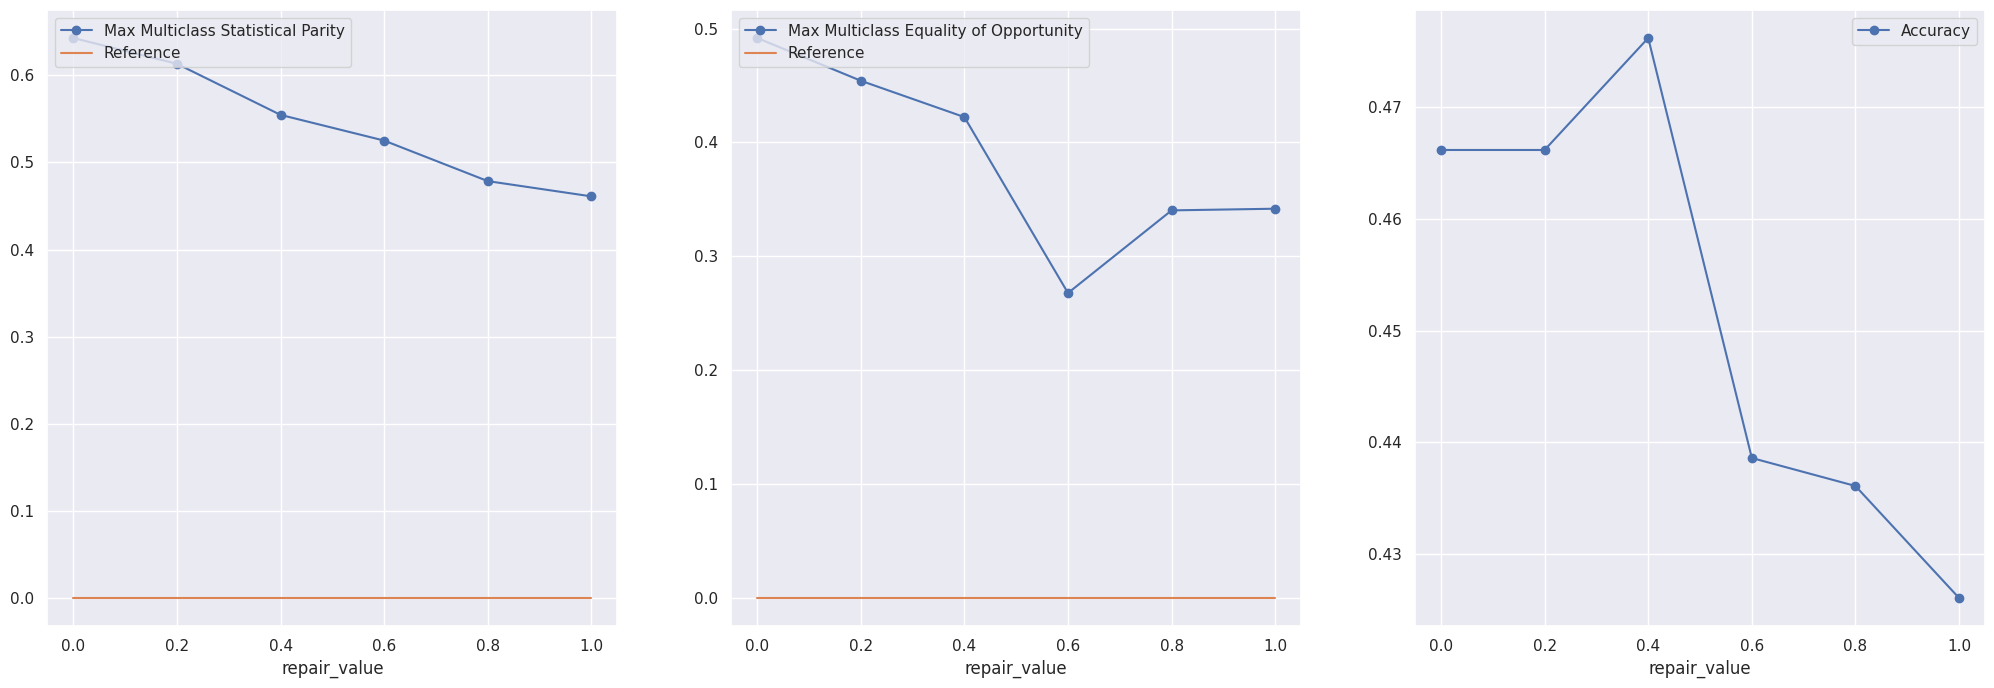

In [ ]:
x_axis = df_metrics.repair_value
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(x_axis, df_metrics['Max Multiclass Statistical Parity'], 'o-', label='Max Multiclass Statistical Parity')
plt.plot(x_axis, np.zeros_like(df_metrics['Max Multiclass Statistical Parity']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('repair_value')
plt.subplot(132)
plt.plot(x_axis, df_metrics['Max Multiclass Equality of Opportunity'], 'o-', label='Max Multiclass Equality of Opportunity')
plt.plot(x_axis, np.zeros_like(df_metrics['Max Multiclass Equality of Opportunity']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('repair_value')
plt.subplot(133)
plt.plot(x_axis, df_metrics['Accuracy'], 'o-', label='Accuracy')
plt.legend(loc='upper right')
plt.xlabel('repair_value')

**6.c Bias mitigation**

**Reweighing: Preprocessing method**

"Reweighing" method is an pre-processing technique that adapts the impact of the training instances by reweighing their importance according to its label and the protected attributes to ensure fairness before classification.

**Traditional implementation**

In [ ]:
from holisticai.bias.mitigation import Reweighing
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

preprocessing_mitigator = Reweighing()

fit_params = {"group_a": group_a, "group_b": group_b}

preprocessing_mitigator.fit(y, **fit_params)

sw = preprocessing_mitigator.estimator_params["sample_weight"]

model = LogisticRegression()

model.fit(X, y, sw)

X, y, group_a, group_b = test_data
fit_params = {"group_a": group_a, "group_b": group_b}

X = scaler.transform(X)
X = preprocessing_mitigator.transform(X, **fit_params)

y_pred = model.predict(X)

p_attr = sensgroup.fit_transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_rew = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_rew

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.569697,0
Mean Multiclass Statistical Parity,0.569697,0
Max Multiclass Equality of Opportunity,0.464632,0
Max Multiclass Average Odds,0.384401,0
Max Multiclass True Positive Difference,0.333193,0
Mean Multiclass Equality of Opportunity,0.464632,0
Mean Multiclass Average Odds,0.384401,0
Mean Multiclass True Positive Difference,0.333193,0


**Pipeline implementation**

In [ ]:
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", Reweighing()),
        ("model", LogisticRegression()),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)

p_attr = sensgroup.transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_rew_w_p = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_rew_w_p

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.569697,0
Mean Multiclass Statistical Parity,0.569697,0
Max Multiclass Equality of Opportunity,0.464632,0
Max Multiclass Average Odds,0.384401,0
Max Multiclass True Positive Difference,0.333193,0
Mean Multiclass Equality of Opportunity,0.464632,0
Mean Multiclass Average Odds,0.384401,0
Mean Multiclass True Positive Difference,0.333193,0


**7.c Results comparison**


In [ ]:
result = pd.concat([df_baseline, df_rew, df_rew_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Max Multiclass Statistical Parity,0.642819,0.569697,0.569697,0
Mean Multiclass Statistical Parity,0.642819,0.569697,0.569697,0
Max Multiclass Equality of Opportunity,0.491702,0.464632,0.464632,0
Max Multiclass Average Odds,0.402064,0.384401,0.384401,0
Max Multiclass True Positive Difference,0.315663,0.333193,0.333193,0
Mean Multiclass Equality of Opportunity,0.491702,0.464632,0.464632,0
Mean Multiclass Average Odds,0.402064,0.384401,0.384401,0
Mean Multiclass True Positive Difference,0.315663,0.333193,0.333193,0


**Dataset**:Body Performance

This is data that confirmed the grade of performance with age and some exercise performance data.

columns
data shape : (13393, 12)

age : 20 ~64

gender : F,M

height_cm : (If you want to convert to feet, divide by 30.48)

weight_kg

body fat_%

diastolic : diastolic blood pressure (min)

systolic : systolic blood pressure (min)

gripForce

sit and bend forward_cm

sit-ups counts

broad jump_cm

class : A,B,C,D ( A: best) / stratified

**Source** : (Korea Sports Promotion Foundation)

In [ ]:
import pandas as pd
df=pd.read_csv("/bodyPerformance.csv")
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [ ]:
df.isnull().sum(), df.shape

(age                        0
 gender                     0
 height_cm                  0
 weight_kg                  0
 body fat_%                 0
 diastolic                  0
 systolic                   0
 gripForce                  0
 sit and bend forward_cm    0
 sit-ups counts             0
 broad jump_cm              0
 class                      0
 dtype: int64,
 (13393, 12))

In [ ]:
df["class"].unique()

array(['C', 'A', 'B', 'D'], dtype=object)

In [ ]:
def preprocess_body_performance_dataset(df, protected_feature):
  """Performs the pre-processing step of the data."""
  # Remove NaN elements from dataframe
  df_ = df.copy()
  df_clean = df_.iloc[:,[i for i,n in enumerate(df_.isna().sum(axis=0).T.values) if n<1000]]
  df_clean = df_clean.dropna()
  # Get the protected attribute vectors
  group_a = df_clean["gender"] == "F"
  group_b = df_clean["gender"] == "M"
  # Remove unnecessary columns
  df_clean.drop(['gender'], axis=1,inplace=True)
  return df_clean, group_a, group_b
df_clean, group_a, group_b = preprocess_body_performance_dataset(df, 'gender')
df.shape, df_clean.shape

((13393, 12), (13393, 11))

<Axes: >

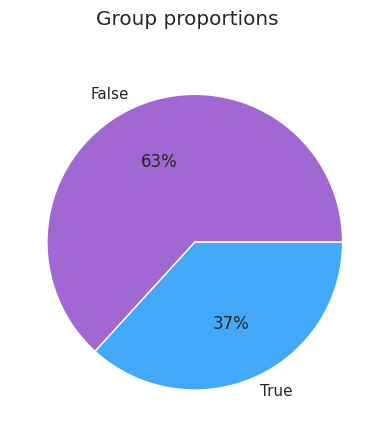

In [ ]:
from holisticai.bias.plots import group_pie_plot

group_pie_plot(group_a)

In [ ]:
X = df_clean.iloc[:, :-1]
y = df_clean.iloc[:, -1]

<Axes: >

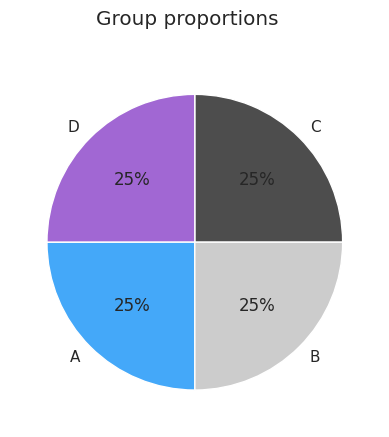

In [ ]:
group_pie_plot(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test, group_a_tr, group_a_ts, group_b_tr, group_b_ts = \
    train_test_split(X, y, group_a, group_b, test_size=0.2, random_state=42)
train_data = X_train, y_train, group_a_tr, group_b_tr
test_data  = X_test, y_test, group_a_ts, group_b_ts

In [ ]:
from holisticai.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from holisticai.utils.transformers.bias import SensitiveGroups
# efficacy metrics from sklearn
from sklearn import metrics

# dictionnary of metrics
metrics_dict={
        "Accuracy": metrics.accuracy_score,
        "Balanced accuracy": metrics.balanced_accuracy_score,}

# efficacy metrics dataframe helper tool
def metrics_dataframe(y_pred, y_true, metrics_dict=metrics_dict):
    metric_list = [[pf, fn(y_true, y_pred)] for pf, fn in metrics_dict.items()]
    return pd.DataFrame(metric_list, columns=["Metric", "Value"]).set_index("Metric")
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

LR = LogisticRegression()
model = LR.fit(X, y)

X, y, group_a, group_b = test_data
X = scaler.transform(X)

y_pred = model.predict(X)
metrics_dataframe(y_pred, y, metrics_dict=metrics_dict)

,Value
Metric,
Accuracy,0.598358
Balanced accuracy,0.595971


In [ ]:
from holisticai.bias.metrics import multiclass_bias_metrics
sensgroup = SensitiveGroups()
p_attr = sensgroup.fit_transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_baseline = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_baseline

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.063207,0
Mean Multiclass Statistical Parity,0.063207,0
Max Multiclass Equality of Opportunity,0.062701,0
Max Multiclass Average Odds,0.048777,0
Max Multiclass True Positive Difference,0.037877,0
Mean Multiclass Equality of Opportunity,0.062701,0
Mean Multiclass Average Odds,0.048777,0
Mean Multiclass True Positive Difference,0.037877,0


Correlation remover: Preprocessing method

In [ ]:
from holisticai.bias.mitigation import CorrelationRemover
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

preprocessing_mitigator = CorrelationRemover()

fit_params = {"group_a": group_a, "group_b": group_b}

X = preprocessing_mitigator.fit_transform(X, **fit_params)

model = LogisticRegression()

model.fit(X, y)

X, y, group_a, group_b = test_data
fit_params = {"group_a": group_a, "group_b": group_b}

X = scaler.transform(X)
X = preprocessing_mitigator.transform(X, **fit_params)

y_pred = model.predict(X)

p_attr = sensgroup.fit_transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_corr_rem = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_corr_rem

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.046294,0
Mean Multiclass Statistical Parity,0.046294,0
Max Multiclass Equality of Opportunity,0.099925,0
Max Multiclass Average Odds,0.076040,0
Max Multiclass True Positive Difference,0.060745,0
Mean Multiclass Equality of Opportunity,0.099925,0
Mean Multiclass Average Odds,0.076040,0
Mean Multiclass True Positive Difference,0.060745,0


In [ ]:
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", CorrelationRemover()),
        ("model", LogisticRegression()),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)

p_attr = sensgroup.transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_corr_rem_w_p = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_corr_rem_w_p

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.046294,0
Mean Multiclass Statistical Parity,0.046294,0
Max Multiclass Equality of Opportunity,0.099925,0
Max Multiclass Average Odds,0.076040,0
Max Multiclass True Positive Difference,0.060745,0
Mean Multiclass Equality of Opportunity,0.099925,0
Mean Multiclass Average Odds,0.076040,0
Mean Multiclass True Positive Difference,0.060745,0


In [ ]:
result = pd.concat([df_baseline, df_corr_rem, df_corr_rem_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Max Multiclass Statistical Parity,0.063207,0.046294,0.046294,0
Mean Multiclass Statistical Parity,0.063207,0.046294,0.046294,0
Max Multiclass Equality of Opportunity,0.062701,0.099925,0.099925,0
Max Multiclass Average Odds,0.048777,0.076040,0.076040,0
Max Multiclass True Positive Difference,0.037877,0.060745,0.060745,0
Mean Multiclass Equality of Opportunity,0.062701,0.099925,0.099925,0
Mean Multiclass Average Odds,0.048777,0.076040,0.076040,0
Mean Multiclass True Positive Difference,0.037877,0.060745,0.060745,0


In [ ]:
def calculate_metrics(train_data, test_data, alpha, metrics_cols):
  from sklearn.metrics import accuracy_score
  model = LogisticRegression()
  pipeline = Pipeline(
      steps=[
          ('scalar', StandardScaler()),
          ("bm_preprocessing", CorrelationRemover(alpha=alpha)),
          ("model", model),
      ]
  )

  X, y, group_a, group_b = train_data
  fit_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b
  }

  pipeline.fit(X, y, **fit_params)

  X, y, group_a, group_b = test_data
  predict_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b,
  }
  y_pred = pipeline.predict(X, **predict_params)
  p_attr = sensgroup.transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

  df = multiclass_bias_metrics(
      p_attr,
      y_pred,
      y,
      metric_type='both'
  )
  # Calculate metrics
  metrics = [
      alpha,
      accuracy_score(y, y_pred)
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics
metrics_val = []
metrics_cols = ['Max Multiclass Statistical Parity', 'Max Multiclass Equality of Opportunity']

for alphas in np.linspace(0,1.5,12):
  metrics_val.append(calculate_metrics(train_data, test_data, alphas, metrics_cols))

metrics = ['alpha', 'accuracy']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

,alpha,accuracy,Max Multiclass Statistical Parity,Max Multiclass Equality of Opportunity
0,0.000000,0.598358,0.063207,0.062701
1,0.136364,0.599104,0.054163,0.059173
2,0.272727,0.603210,0.048349,0.064591
3,0.409091,0.603210,0.033732,0.087270
4,0.545455,0.600224,0.029477,0.105972
5,0.681818,0.605823,0.040941,0.118789
6,0.818182,0.608809,0.050244,0.123800
7,0.954545,0.610676,0.052329,0.113625
8,1.090909,0.617021,0.032018,0.078907
9,1.227273,0.620381,0.053537,0.035537


Text(0.5, 0, 'alpha')

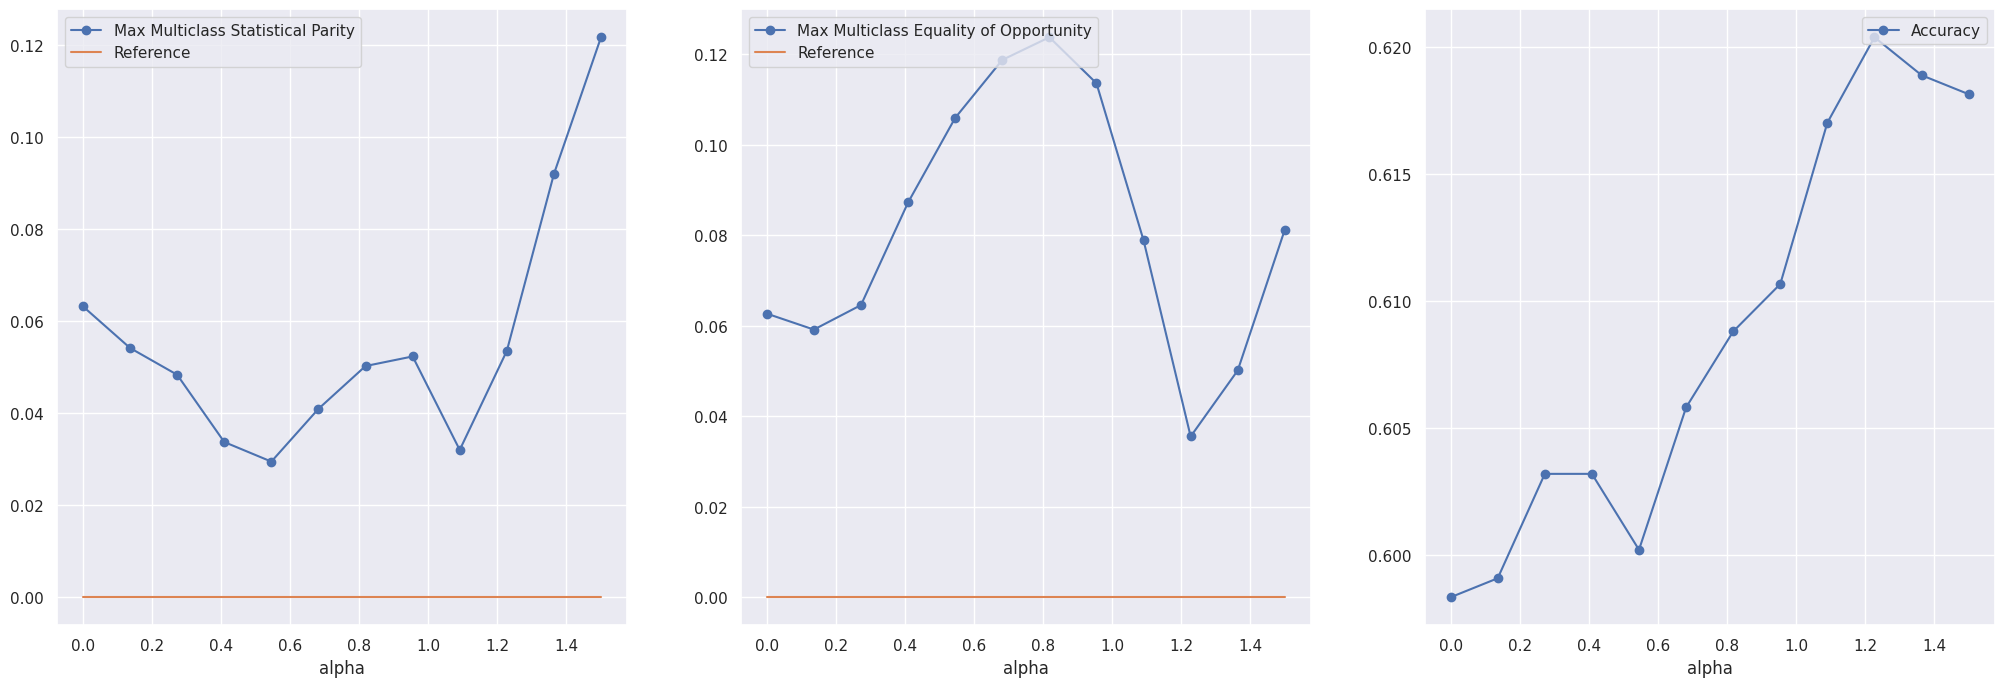

In [ ]:
import matplotlib.pyplot as plt
x_axis = df_metrics.alpha
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(x_axis, df_metrics['Max Multiclass Statistical Parity'], 'o-', label='Max Multiclass Statistical Parity')
plt.plot(x_axis, np.zeros_like(df_metrics['Max Multiclass Statistical Parity']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.subplot(132)
plt.plot(x_axis, df_metrics['Max Multiclass Equality of Opportunity'], 'o-', label='Max Multiclass Equality of Opportunity')
plt.plot(x_axis, np.zeros_like(df_metrics['Max Multiclass Equality of Opportunity']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('alpha')
plt.subplot(133)
plt.plot(x_axis, df_metrics['accuracy'], 'o-', label='Accuracy')
plt.legend(loc='upper right')
plt.xlabel('alpha')

Disparate impact remover: Preprocessing method

In [ ]:
from holisticai.bias.mitigation import DisparateImpactRemover
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

preprocessing_mitigator = DisparateImpactRemover()

fit_params = {"group_a": group_a, "group_b": group_b}

X = preprocessing_mitigator.fit_transform(X, **fit_params)

model = LogisticRegression()

model.fit(X, y)

X, y, group_a, group_b = test_data
fit_params = {"group_a": group_a, "group_b": group_b}

X = scaler.transform(X)
X = preprocessing_mitigator.transform(X, **fit_params)

y_pred = model.predict(X)

p_attr = sensgroup.fit_transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_disprem = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_disprem

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.118971,0
Mean Multiclass Statistical Parity,0.118971,0
Max Multiclass Equality of Opportunity,0.243368,0
Max Multiclass Average Odds,0.181452,0
Max Multiclass True Positive Difference,0.168063,0
Mean Multiclass Equality of Opportunity,0.243368,0
Mean Multiclass Average Odds,0.181452,0
Mean Multiclass True Positive Difference,0.168063,0


In [ ]:
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", DisparateImpactRemover()),
        ("model", LogisticRegression()),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)

p_attr = sensgroup.transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_disprem_w_p = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_disprem_w_p

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.118971,0
Mean Multiclass Statistical Parity,0.118971,0
Max Multiclass Equality of Opportunity,0.243368,0
Max Multiclass Average Odds,0.181452,0
Max Multiclass True Positive Difference,0.168063,0
Mean Multiclass Equality of Opportunity,0.243368,0
Mean Multiclass Average Odds,0.181452,0
Mean Multiclass True Positive Difference,0.168063,0


In [ ]:
result = pd.concat([df_baseline, df_disprem, df_disprem_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Max Multiclass Statistical Parity,0.063207,0.118971,0.118971,0
Mean Multiclass Statistical Parity,0.063207,0.118971,0.118971,0
Max Multiclass Equality of Opportunity,0.062701,0.243368,0.243368,0
Max Multiclass Average Odds,0.048777,0.181452,0.181452,0
Max Multiclass True Positive Difference,0.037877,0.168063,0.168063,0
Mean Multiclass Equality of Opportunity,0.062701,0.243368,0.243368,0
Mean Multiclass Average Odds,0.048777,0.181452,0.181452,0
Mean Multiclass True Positive Difference,0.037877,0.168063,0.168063,0


In [ ]:
def calculate_metrics(train_data, test_data, repair_level, metrics_cols):
  from sklearn.metrics import accuracy_score
  model = LogisticRegression()
  pipeline = Pipeline(
      steps=[
          ('scalar', StandardScaler()),
          ("bm_preprocessing", DisparateImpactRemover(repair_level=repair_level)),
          ("model", model),
      ]
  )

  X, y, group_a, group_b = train_data
  fit_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b
  }

  pipeline.fit(X, y, **fit_params)

  X, y, group_a, group_b = test_data
  predict_params = {
      "bm__group_a": group_a,
      "bm__group_b": group_b,
  }
  y_pred = pipeline.predict(X, **predict_params)
  p_attr = sensgroup.transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

  df = multiclass_bias_metrics(
      p_attr,
      y_pred,
      y,
      metric_type='both'
  )
  # Calculate metrics
  metrics = [
      repair_level,
      accuracy_score(y, y_pred)
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics
metrics_val = []
metrics_cols = ['Max Multiclass Statistical Parity', 'Max Multiclass Equality of Opportunity']

for repair_values in np.linspace(0,1,6):
  metrics_val.append(calculate_metrics(train_data, test_data, repair_values, metrics_cols))

metrics = ['repair_value', 'Accuracy']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

,repair_value,Accuracy,Max Multiclass Statistical Parity,Max Multiclass Equality of Opportunity
0,0.0,0.598358,0.063207,0.062701
1,0.2,0.590519,0.041770,0.081682
2,0.4,0.585293,0.040829,0.119731
3,0.6,0.580814,0.076181,0.180669
4,0.8,0.579321,0.112374,0.246614
5,1.0,0.590146,0.118971,0.243368


Text(0.5, 0, 'repair_value')

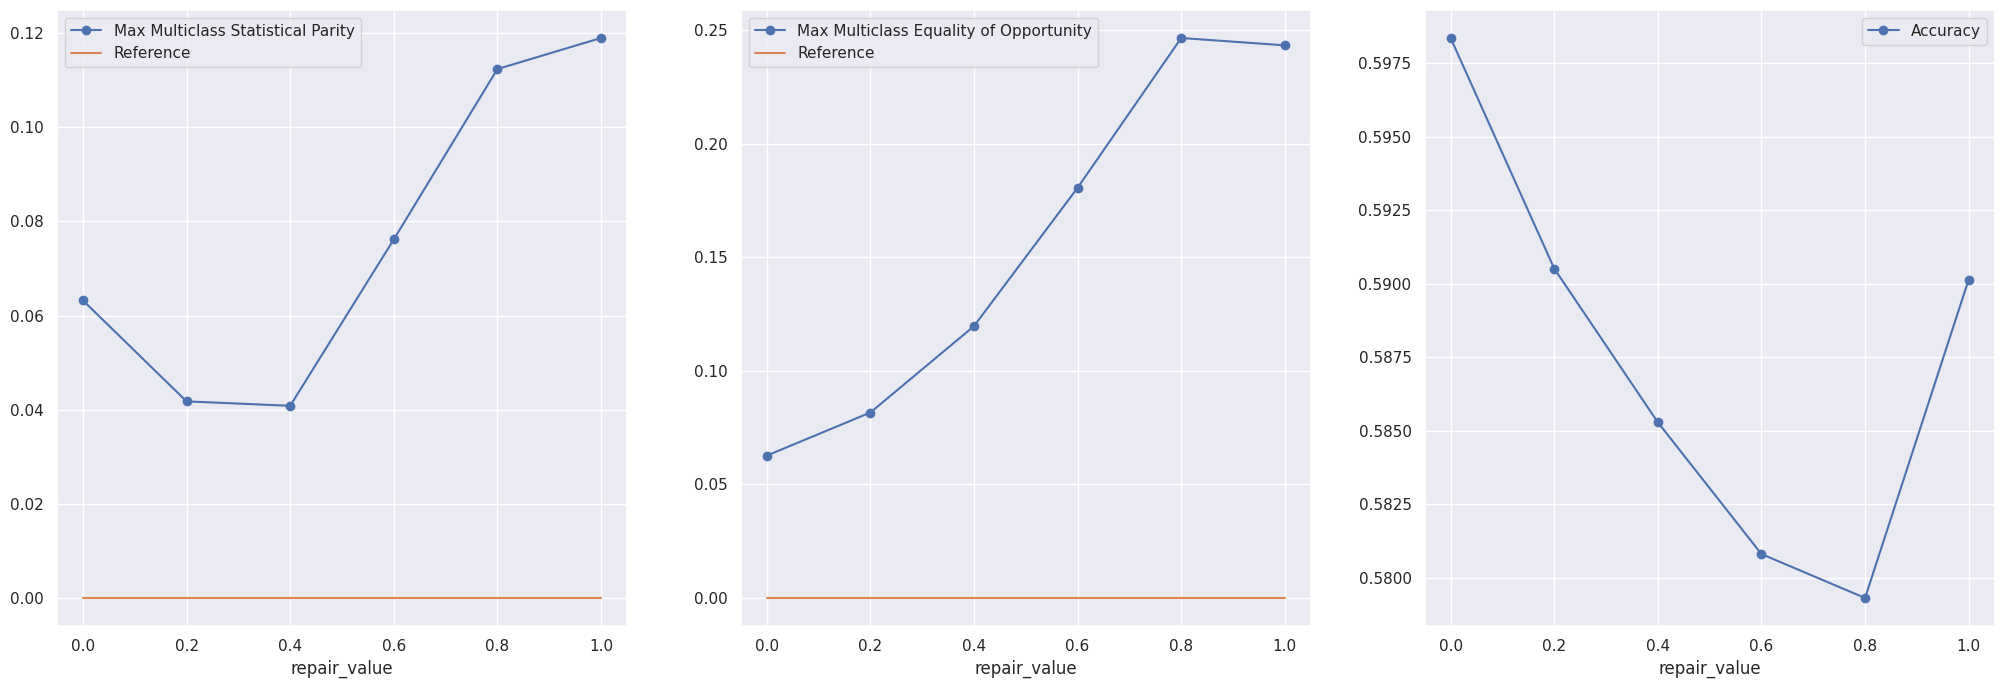

In [ ]:
x_axis = df_metrics.repair_value
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(x_axis, df_metrics['Max Multiclass Statistical Parity'], 'o-', label='Max Multiclass Statistical Parity')
plt.plot(x_axis, np.zeros_like(df_metrics['Max Multiclass Statistical Parity']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('repair_value')
plt.subplot(132)
plt.plot(x_axis, df_metrics['Max Multiclass Equality of Opportunity'], 'o-', label='Max Multiclass Equality of Opportunity')
plt.plot(x_axis, np.zeros_like(df_metrics['Max Multiclass Equality of Opportunity']), label='Reference')
plt.legend(loc='upper left')
plt.xlabel('repair_value')
plt.subplot(133)
plt.plot(x_axis, df_metrics['Accuracy'], 'o-', label='Accuracy')
plt.legend(loc='upper right')
plt.xlabel('repair_value')

Reweighing: Preprocessing method

In [ ]:
from holisticai.bias.mitigation import Reweighing
X, y, group_a, group_b = train_data

scaler = StandardScaler()
X = scaler.fit_transform(X)

preprocessing_mitigator = Reweighing()

fit_params = {"group_a": group_a, "group_b": group_b}

preprocessing_mitigator.fit(y, **fit_params)

sw = preprocessing_mitigator.estimator_params["sample_weight"]

model = LogisticRegression()

model.fit(X, y, sw)

X, y, group_a, group_b = test_data
fit_params = {"group_a": group_a, "group_b": group_b}

X = scaler.transform(X)
X = preprocessing_mitigator.transform(X, **fit_params)

y_pred = model.predict(X)

p_attr = sensgroup.fit_transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_rew = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_rew

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.057063,0
Mean Multiclass Statistical Parity,0.057063,0
Max Multiclass Equality of Opportunity,0.087035,0
Max Multiclass Average Odds,0.068230,0
Max Multiclass True Positive Difference,0.055368,0
Mean Multiclass Equality of Opportunity,0.087035,0
Mean Multiclass Average Odds,0.068230,0
Mean Multiclass True Positive Difference,0.055368,0


In [ ]:
pipeline = Pipeline(
    steps=[
        ('scalar', StandardScaler()),
        ("bm_preprocessing", Reweighing()),
        ("model", LogisticRegression()),
    ]
)

X, y, group_a, group_b = train_data
fit_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b
}

pipeline.fit(X, y, **fit_params)

X, y, group_a, group_b = test_data
predict_params = {
    "bm__group_a": group_a,
    "bm__group_b": group_b,
}
y_pred = pipeline.predict(X, **predict_params)

p_attr = sensgroup.transform(np.stack([group_a,group_b], axis=1), convert_numeric=True)

df_rew_w_p = multiclass_bias_metrics(
    p_attr,
    y_pred,
    y,
    metric_type='both'
)
df_rew_w_p

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.057063,0
Mean Multiclass Statistical Parity,0.057063,0
Max Multiclass Equality of Opportunity,0.087035,0
Max Multiclass Average Odds,0.068230,0
Max Multiclass True Positive Difference,0.055368,0
Mean Multiclass Equality of Opportunity,0.087035,0
Mean Multiclass Average Odds,0.068230,0
Mean Multiclass True Positive Difference,0.055368,0


In [ ]:
result = pd.concat([df_baseline, df_rew, df_rew_w_p], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Mitigator without pipeline',"Mitigator with pipeline", 'Reference']
result

,Baseline,Mitigator without pipeline,Mitigator with pipeline,Reference
Metric,,,,
Max Multiclass Statistical Parity,0.063207,0.057063,0.057063,0
Mean Multiclass Statistical Parity,0.063207,0.057063,0.057063,0
Max Multiclass Equality of Opportunity,0.062701,0.087035,0.087035,0
Max Multiclass Average Odds,0.048777,0.068230,0.068230,0
Max Multiclass True Positive Difference,0.037877,0.055368,0.055368,0
Mean Multiclass Equality of Opportunity,0.062701,0.087035,0.087035,0
Mean Multiclass Average Odds,0.048777,0.068230,0.068230,0
Mean Multiclass True Positive Difference,0.037877,0.055368,0.055368,0
